# Data analysis and preprocessing

In [1]:
import gc
import re
import data_preprocessing as dpp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from auxiliar_functions import extract_info
# global
data_path = '../Data/'

## Lost values

In [2]:
# load and merge data
# important: del and gc calls for performance and memory issues.
df_train = pd.read_csv(data_path + 'train.csv', dtype={'target': np.uint8})
df_members = pd.read_csv(data_path + 'members.csv')
df_merged = df_train.merge(df_members, on='msno', how='left')
del df_train, df_members
gc.collect()
df_songs = pd.read_csv(data_path + 'songs.csv')
df_merged = df_merged.merge(df_songs, on='song_id', how='left')
del df_songs
gc.collect()
df_song_extra = pd.read_csv(data_path + 'song_extra_info.csv', nrows=None)
df_merged = df_merged.merge(df_song_extra, on='song_id', how='left')
del df_song_extra
gc.collect()
print('nrows: {}\n'.format(len(df_merged)))
df_merged.head()

nrows: 7377418



,msno,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,registration_init_time,expiration_date,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,NaN,7,20120102,20171005,206471.0,359,Bastille,Dan Smith| Mark Crew,NaN,52.0,Good Grief,GBUM71602854
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24,female,9,20110525,20170911,284584.0,1259,Various Artists,NaN,NaN,52.0,Lords of Cardboard,US3C69910183
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24,female,9,20110525,20170911,225396.0,1259,Nas,N. Jones、W. Adams、J. Lordan、D. Ingle,NaN,52.0,Hip Hop Is Dead(Album Version (Edited)),USUM70618761
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,13,24,female,9,20110525,20170911,255512.0,1019,Soundway,Kwadwo Donkoh,NaN,-1.0,Disco Africa,GBUQH1000063
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1,0,NaN,7,20120102,20171005,187802.0,1011,Brett Young,Brett Young| Kelly Archer| Justin Ebach,NaN,52.0,Sleep Without You,QM3E21606003


In [3]:
merged_info = extract_info(df_merged)
merged_info

,null_count,null_percentage,dtypes
msno,0,0.000000,object
song_id,0,0.000000,object
source_system_tab,24849,0.336825,object
source_screen_name,414804,5.622618,object
source_type,21539,0.291959,object
target,0,0.000000,uint8
city,0,0.000000,int64
bd,0,0.000000,int64
gender,2961479,40.142486,object
registered_via,0,0.000000,int64


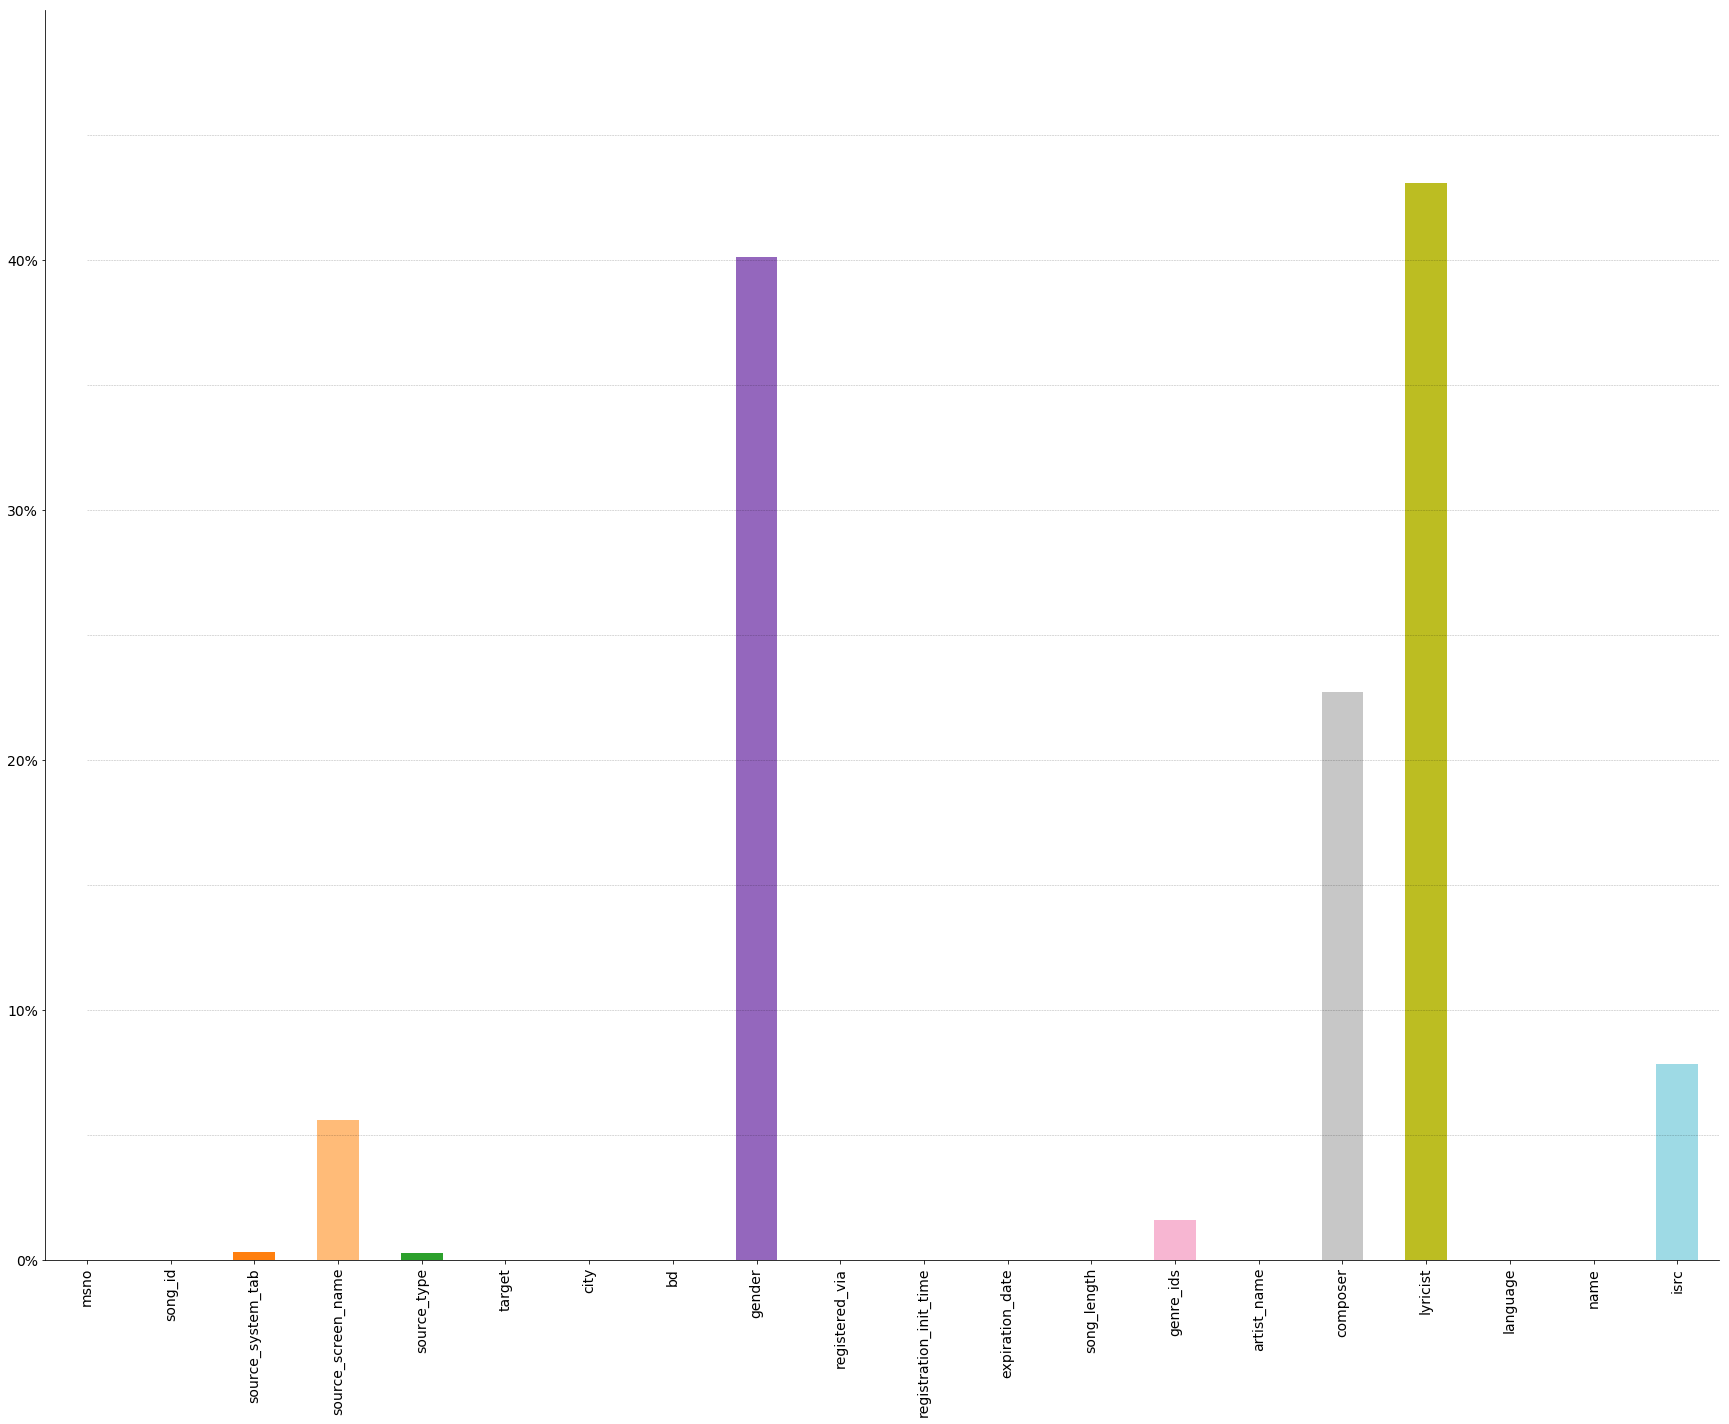

In [4]:
dpp.plot_lost_values_percent(merged_info['null_percentage'])

## Outliers: bd feature

In [5]:
df_merged['bd'] = df_merged['bd'].apply(dpp.bd_nanify_outlier)

In [6]:
extract_info(df_merged).loc['bd']

null_count         2966437
null_percentage    40.2097
dtypes             float64
Name: bd, dtype: object

In [7]:
bd_mean = df_merged['bd'].mean()
bd_mean

28.78537699436928

In [8]:
df_merged['bd'] = df_merged['bd'].fillna(bd_mean).astype(np.uint8)
extract_info(df_merged).loc['bd']

null_count             0
null_percentage        0
dtypes             uint8
Name: bd, dtype: object

## Gender imputation: KNN

In [66]:
lcats_gender_comp = ['msno', 'gender', 'bd', 'registration_init_time', 'expiration_date']
df_merged[lcats_gender_comp] = dpp.fill_na_gender_knn(df_merged[lcats_gender_comp])

AttributeError: module 'data_preprocessing' has no attribute 'fill_na_gender_knn'

## Feature analysis: composer and lyricist

Number of categories composers:

In [6]:
len(dpp.make_set_categories(df_merged['composer']))

81566

Number of categories lyricists:

In [8]:
len(dpp.make_set_categories(df_merged['lyricist']))

38473

## Remove features

In [3]:
df_merged = df_merged.drop(columns=['msno', 'song_id', 'composer', 'lyricist'])
df_merged.head()

,source_system_tab,source_screen_name,source_type,target,city,bd,gender,registered_via,registration_init_time,expiration_date,song_length,genre_ids,artist_name,language,name,isrc
0,explore,Explore,online-playlist,1,1,0,NaN,7,20120102,20171005,206471.0,359,Bastille,52.0,Good Grief,GBUM71602854
1,my library,Local playlist more,local-playlist,1,13,24,female,9,20110525,20170911,284584.0,1259,Various Artists,52.0,Lords of Cardboard,US3C69910183
2,my library,Local playlist more,local-playlist,1,13,24,female,9,20110525,20170911,225396.0,1259,Nas,52.0,Hip Hop Is Dead(Album Version (Edited)),USUM70618761
3,my library,Local playlist more,local-playlist,1,13,24,female,9,20110525,20170911,255512.0,1019,Soundway,-1.0,Disco Africa,GBUQH1000063
4,explore,Explore,online-playlist,1,1,0,NaN,7,20120102,20171005,187802.0,1011,Brett Young,52.0,Sleep Without You,QM3E21606003


In [17]:
df_merged = df_merged[['source_system_tab', 'source_screen_name']]
df_merged.head()
Remove features¶
In [3]:

df_merged = df_merged.drop(columns=['msno', 'song_id', 'composer', 'lyricist'])
df_merged.head()
Out[3]:


,source_system_tab,source_screen_name
0,explore,Explore
1,my library,Local playlist more
2,my library,Local playlist more
3,my library,Local playlist more
4,explore,Explore


In [5]:
len(dpp.make_set_categories(df_merged['source_system_tab']))

8

In [21]:
len(dpp.make_set_categories(df_merged['source_screen_name']))

20

In [55]:
len(dpp.make_set_categories(df_merged['city']))

21